In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import cv2
from sklearn import metrics
import threading as th
from tqdm import tqdm as progress_bar

In [2]:
!ls


 best_circle_imgs
'best_circle_imgs (copy)'
 best_so_far.png
 best_X_imgs
'download (1).png'
 download.png
 last_population_11k_with_sigmas.npy
 last_population_30k_with_sigmas.npy
 last_population.npy
 last_sigmas_11k.npy
 last_sigmas_30k.npy
 last_sigmas.npy
 Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF.jpg
 population_30k_kindaok.npy
 population_background.npy
 population_continuation_with_sigmas.npy
 population.npy
 projekt.ipynb
 README.md
 result_30k.png
 sigmas_continuation_with_sigmas.npy
 sigmas.npy
 todo.txt


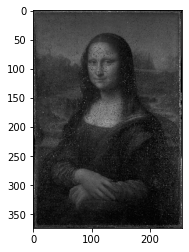

In [22]:
resize_to=256
target_img=cv2.imread('./Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF.jpg')
#Image.open('./Mona_Lisa,_by_Leonardo_da_Vinci,_from_C2RMF_retouched.jpg')
target_img=cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)

hw_ratio=target_img.shape[0]/target_img.shape[1]
target_img=cv2.resize(target_img, (resize_to, int(hw_ratio*resize_to))) # widtxXheight
target_img=np.asarray(target_img)/255

plt.imshow(target_img, cmap='gray')
plt.show()

# ES

In [8]:
def draw_individual(X_img, gray=True):
    figure(figsize=(4, 3), dpi=80)
    if gray:
        plt.imshow(X_img, cmap='gray')
    else:
        plt.imshow(X_img)
    plt.show()
def save_individual_img(X_img, gray=True, no_iter=0, dir_path='./best_circle_imgs/'):
    figure(figsize=(4, 3), dpi=80)
    if gray:
        plt.imshow(X_img, cmap='gray')
    else:
        plt.imshow(X_img)
    plt.savefig(dir_path+f'iter_{no_iter}')
    plt.show()

In [23]:
class EvoulationStrategy:
    def __init__(self, 
                initial_chromosome_length,
                genotype_length,
                population_size, 
                 
                target_img,
                gray=False,
                ):
        
        self.chromosome_length=initial_chromosome_length
        self.initial_chromosome_length=initial_chromosome_length
        self.genotype_length=genotype_length
        self.population_size=population_size
    
        self.target_img=target_img
        self.max_radius=np.sqrt(pow(self.target_img.shape[0],2)+pow(self.target_img.shape[1], 2))/2
        self.gray=gray
    
        self.population=None#np.empty((self.population_size, self.initil_chromosome_length, self.genotype_length))
        # circles already in good position, modify only those in self.population
        # preferably array representing image, to save time during eval
        self.population_background=None 
        self.sigmas=None#np.empty((self.population_size, self.genotype_length))
        self.curr_iter=0
        self.evals=None
        
    def random_circle(self, max_radius_scale=1.0, max_opacity_scale=1.0,
                      x_min=0, x_max=1, y_min=0, y_max=1):
        if self.gray:
            lows=np.zeros(self.genotype_length)
            highs=np.ones(self.genotype_length)
        else:
            lows=np.zeros(self.genotype_length)
            highs=np.ones(self.genotype_length)
            
        lows[0]=x_min
        highs[0]=x_max
        lows[1]=y_min
        highs[1]=y_max
        
        lows[2]=0.125*max_radius_scale
        highs[2]=1.0*max_radius_scale
        highs[3]=1.0* max_opacity_scale

        circle=np.random.uniform(lows, highs, self.genotype_length)
        return circle

    def random_individual(self, chrom_length, max_radius_scale=1.0,  max_opacity_scale=1.0,
                          x_min=0, x_max=1, y_min=0, y_max=1):
        indiv = np.zeros((chrom_length, self.genotype_length))

        for i in range(chrom_length):
            indiv[i] = self.random_circle(max_radius_scale, 
                                          max_opacity_scale,
                                          x_min, x_max, 
                                          y_min, y_max)
        return indiv

    def random_population(self, chrom_length,
                          max_radius_scale=1.0, max_opacity_scale=1.0,
                          x_mins=[0], x_maxs=[1], y_mins=[0], y_maxs=[1]
                         ):
        population = np.zeros((self.population_size, chrom_length, self.genotype_length))
        if len(x_mins)==1:
            for i in range(self.population_size):
                population[i] = self.random_individual(chrom_length,
                                                       max_radius_scale, max_opacity_scale,
                                                       x_mins[0], x_maxs[0], y_mins[0], y_maxs[0])
        else:
            for i in range(self.population_size):
                population[i] = self.random_individual(chrom_length,
                                                       max_radius_scale, max_opacity_scale,
                                                       x_mins[i], x_maxs[i], y_mins[i], y_maxs[i])
        return population

    def represent_individual(self, X, X_img=None):
        if isinstance(X_img, type(None)): 
            X_img=np.zeros(self.target_img.shape)
        for c in X:
            #[x, y, radius, opacity, r, g, b]
            x=int(c[0]*self.target_img.shape[1])
            y=int(c[1]*self.target_img.shape[0])
            radius=int(c[2]*self.max_radius)
            opacity=c[3]
            rgb=c[4:]
            circle_img=cv2.circle(X_img.copy(), 
                                  (x, y), 
                                  radius, 
                                  rgb,
                                  thickness=-1)
            X_img=cv2.addWeighted(X_img, 1-opacity, circle_img, opacity, 0)
        return X_img
    
    def f(self, X_img, target=None):
        if isinstance(target, type(None)):
            target=self.target_img
        #return metrics.mean_squared_error(flatten_target_image, X_img.flatten())
        pom = target - X_img
        return np.sum(pom*pom)
    
    def evaluate_individual(self, solutions, background, evals, i):
        evals[i]=self.f(self.represent_individual(solutions[i], background[i].copy()))
    def get_region_for_individual(self, i, no_split=4, targets=None):
        '''
        returns (upper left, lower right) points for part of image with the highest MSE  
        '''
        X=self.represent_individual(self.population[i], self.population_background[i].copy())

        # split into rows
        pom=np.array_split(X, no_split, axis=0)
        # split rows into cols
        pom=[np.array_split(p, no_split, axis=1) for p in pom]
        Xs=[]
        y=0
        for  po in (pom):
            x=0
            for  p in (po):
                Xs.append((p, 
                           (x, y), 
                           (x+p.shape[1], y+p.shape[0])))
                x+=p.shape[1]
            y+=po[0].shape[0]
            
        evals=np.asarray([self.f(X_part[0], target_part) for X_part, target_part in zip(Xs, targets)])
      #  print(evals)
        fitness_values = evals - evals.min() + 1e-10
        fitness_values = fitness_values / fitness_values.sum()
        idx = np.random.choice(no_split*no_split, 1, True, fitness_values).item()
        return Xs[idx][1], Xs[idx][2]
        
    def mutate_X(self, X, sigmas=None):
        no_figures_to_mutate=np.random.randint(1, X.shape[0]//2)
        figures_to_mutate=np.random.choice(np.arange(X.shape[0]), no_figures_to_mutate, replace=False)

        clip_lows=np.zeros(X.shape[1])
      #  clip_highs=np.ones(solutions[i].shape[1])
        clip_lows[2]=1/64 # minimal radius
        clip_lows[3]=1/64 # miniaml opacity

        X[figures_to_mutate]=np.clip(X[figures_to_mutate]+(np.random.random((no_figures_to_mutate,
                                                                             X.shape[1]))-0.5)*sigmas, 
                                     clip_lows, 1)
        return X

    def mutate_sigmas(self, sigmas, scale=1e-3, mut_prob=0.5):
        mutation_indices = (np.random.random(sigmas.shape) < mut_prob).astype(float)
        sigmas += mutation_indices * np.random.normal(loc=0, scale=scale, size=sigmas.shape)
        sigmas= np.clip(sigmas, 1e-4, 1e-1)
        return sigmas

    def mutate_X_thred(self, solutions, i, sigmas=None):
        no_figures_to_mutate=np.random.randint(1, solutions[i].shape[0]//2)
        figures_to_mutate=np.random.choice(np.arange(solutions[i].shape[0]), no_figures_to_mutate, replace=False)

        clip_lows=np.zeros(solutions[i].shape[1])
      #  clip_highs=np.ones(solutions[i].shape[1])
        clip_lows[2]=1/64 # minimal radius
        clip_lows[3]=1/64 # miniaml opacity

        solutions[i,figures_to_mutate]=np.clip(solutions[i,figures_to_mutate]+(np.random.random((
                                                                   no_figures_to_mutate,
                                                                   solutions[i].shape[1]))-0.5)*sigmas[i], 
                                               clip_lows, 1)

    def train(self,
            number_of_iterations=30000, 
            number_of_parents=6, 
            number_of_offspring_per_parent=3, 
            max_chromosome_length=256,
            initial_sigma_scale=5e-2,
            add_cricle_threshold=5e-3,
            log_frequency=1,
            update_frequency=100,
            no_added_circels=1,
            pararell=True
        ):
        best_solution = np.zeros((max_chromosome_length, self.genotype_length))
        best_solution_background = np.zeros(self.target_img.shape)
        best_solution_objective_value = np.inf


        log_objective_values = np.zeros((number_of_iterations, 4))
        log_best_solutions = []#np.zeros((number_of_iterations, max_chromosome_length, genotype_length))
        log_best_backgrounds = []
       # log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

        # generating an initial population
        if not isinstance(self.population, np.ndarray):
            self.population=self.random_population(self.chromosome_length)
        if not isinstance(self.population_background, np.ndarray):
            self.population_background=np.zeros((self.population_size, *self.target_img.shape))
        # SIGMAS individualXcircle parameters (mutation scale)
        if not isinstance(self.sigmas, np.ndarray):
            self.sigmas = initial_sigma_scale * np.ones((self.population_size, self.genotype_length))

        # evaluating the objective function on the current population
        self.evals=np.ones(self.population_size)
        if pararell:
            threads=[]
            for i in range(self.population_size):
                t=th.Thread(target=self.evaluate_individual, args=[self.population, self.population_background, self.evals, i])
                t.start()
                threads.append(t)
            for t in threads:
                t.join()
        else:
            self.evals = np.asarray([self.f(self.represent_individual(X)) for X in self.population])

        try:
            times_circles_were_added=0#1+self.population.shape[1]//(2*self.initial_chromosome_length) 
            # initial creation of population
            last_update_iter=0
            initial_no_split=2
           # start_mutations_scale=mutation_scale
            for no_iter in progress_bar(range(number_of_iterations)):
                self.curr_iter=no_iter
                # selecting the parent indices by the roulette wheel method
                # MAXIMIZE
                #fitness_values = self.evals - self.evals.min()
                # MINIMIZE
                fitness_values = self.evals.max() - self.evals
                if fitness_values.sum() > 0:
                    fitness_values = fitness_values / fitness_values.sum()
                else:
                    fitness_values = 1.0 / self.population_size * np.ones(self.population_size)
                parent_indices = np.random.choice(self.population_size, 
                                                  number_of_parents, True, fitness_values).astype(np.int64)

                # creating the children population by Global Intermediere Recombination
                children_list=[]
                children_background_list=[]
                children_sigmas_list=[]
                for i in range(number_of_offspring_per_parent):
                    children_list.append(self.population[parent_indices].copy())          
                    children_background_list.append(self.population_background[parent_indices].copy())          
                    children_sigmas_list.append(self.sigmas[parent_indices].copy())          
                children_population_solutions = np.vstack(children_list)
                children_population_backgrounds = np.vstack(children_background_list)
                children_population_sigmas = np.vstack(children_sigmas_list)

                children_population_sigmas=self.mutate_sigmas(children_population_sigmas)
                if pararell:
                    threads=[]
                    for i in range(children_population_solutions.shape[0]):
                        t=th.Thread(target=self.mutate_X_thred, args=[children_population_solutions, 
                                                                      i, children_population_sigmas])
                        t.start()
                        threads.append(t)
                    for t in threads:
                        t.join()
                else:
                    for i in range(children_population_solutions.shape[0]):
                        children_population_solutions[i]=self.mutate_X(children_population_solutions[i], 
                                                                  children_population_sigmas[i])

                # evaluating the objective function on the children population
                children_population_objective_values=np.ones(number_of_offspring_per_parent*number_of_parents)
                if pararell:
                    threads=[]
                    for i in range(children_population_solutions.shape[0]):
                        t=th.Thread(target=self.evaluate_individual, args=[children_population_solutions,
                                                                           children_population_backgrounds,
                                                                           children_population_objective_values,
                                                                           i] )
                        t.start()
                        threads.append(t)
                    for t in threads:
                        t.join()
                else:
                    children_population_objective_values = [self.f(self.represent_individual(X)) for X in children_population_solutions]

                # replacing the current population by (Mu + Lambda) Replacement
                self.evals = np.hstack([self.evals, 
                                        children_population_objective_values])
                self.population = np.vstack([self.population, 
                                             children_population_solutions])
                self.population_background = np.vstack([self.population_background, 
                                             children_population_backgrounds])
                self.sigmas = np.vstack([self.sigmas, 
                                         children_population_sigmas])

                I = np.argsort(self.evals)#[::-1]
                self.population = self.population[I[:self.population_size], :]
                self.population_background = self.population_background[I[:self.population_size], :]
                self.sigmas = self.sigmas[I[:self.population_size], :]
                self.evals = self.evals[I[:self.population_size]]

                # recording some statistics
                if best_solution_objective_value > self.evals[0]:
                    best_solution = self.population[0, :]
                    best_solution_background=self.population_background[0, :]
                    best_solution_objective_value = self.evals[0]

                log_objective_values[no_iter, :] = [self.evals.min(), 
                                                    self.evals.max(),
                                                    self.evals.mean(), 
                                                    self.evals.std()]

                if np.mod(no_iter, update_frequency) == 0 and \
                   no_iter-last_update_iter>=update_frequency*2 and \
                   self.population.shape[1]<max_chromosome_length:

                        prev=np.mean(log_objective_values[no_iter-2*update_frequency:no_iter-update_frequency])
                        curr=np.mean(log_objective_values[no_iter-update_frequency:no_iter+1])
                        if (prev-curr)/prev < add_cricle_threshold*np.power(0.995, times_circles_were_added): # ADD CIRCLES

                            last_update_iter=no_iter
                            times_circles_were_added+=1
                            best_solution_objective_value=np.inf
                          #  mutation_scale=start_mutations_scale/times_circles_were_added

                            radius_scale=1/np.log2(1+times_circles_were_added*2)
                            if radius_scale<1/32:
                                radius_scale=1/32
                            no_split=np.power(initial_no_split, 
                                              int(np.floor(max(np.log(times_circles_were_added)-1, 1))))
                            if no_split>32:
                                no_split=32
                            print(f'''Adding circles {times_circles_were_added}th time. 
                                      \n Split target image into {no_split*no_split} rectangles.
                                      \n Radius_scale={radius_scale}''')
                   
                            #create new  circles
                            pom=np.array_split(self.target_img, no_split, axis=0)
                            # split rows into cols
                            pom=[np.array_split(p, no_split, axis=1) for p in pom]
                            targets=[]
                            for  po in (pom):
                                for  p in (po):
                                    targets.append(p)
                            
                            xmins=[]
                            ymins=[]
                            xmaxs=[]
                            ymaxs=[]
                            for idx in range(self.population_size):
                                # left upper, right lower  ((lu_x, lu_y),(rl_x, rl_y))
                                lu, rl=self.get_region_for_individual(idx, 
                                                                            no_split=no_split, 
                                                                            targets=targets)
                                xmins.append(lu[0]/self.target_img.shape[1])
                                ymins.append(lu[1]/self.target_img.shape[0])
                                xmaxs.append(rl[0]/self.target_img.shape[1])
                                ymaxs.append(rl[1]/self.target_img.shape[0])
                            
                            new_pop=self.random_population(chrom_length=no_added_circels, 
                                                           max_radius_scale=radius_scale,
                                                           max_opacity_scale=0.5,
                                                           x_mins=xmins, x_maxs=xmaxs,
                                                           y_mins=ymins, y_maxs=ymaxs
                                                          )

                            # save old circles in background, remove them from population
                            old_circles=self.population[:,:no_added_circels,:]
                            self.population=self.population[:,no_added_circels:,:]
                            for c_i, c in enumerate(old_circles):
                                self.population_background[c_i]=self.represent_individual(X=c, 
                                                                                          X_img=self.population_background[c_i])
                            
                            self.population=np.concatenate([self.population, new_pop], 
                                                            axis=1)
                            if pararell:
                                threads=[]
                                for i in range(self.population_size):
                                    t=th.Thread(target=self.evaluate_individual, args=[self.population,
                                                                                       self.population_background,
                                                                                      self.evals, 
                                                                                      i])
                                    t.start()
                                    threads.append(t)
                                for t in threads:
                                    t.join()
                            else:
                                self.evals = np.asarray([self.f(self.represent_individual(X)) for X in self.population])

                
                
                if np.mod(no_iter, log_frequency) == 0 or no_iter==number_of_iterations-1:

                    np.save('./population', self.population)
                    np.save('./population_background', self.population_background)
                    np.save('./sigmas', self.sigmas)
                    
                    if np.mod(no_iter, number_of_iterations//10)==0:
                        log_best_solutions.append(self.population[0, :])
                        log_best_backgrounds.append(self.population_background[0, :])
                    print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (no_iter, 
                                                                                        log_objective_values[no_iter, 0], 
                                                                                        log_objective_values[no_iter, 2]
                                                                                                               ))
                    #draw_individual(represent_individual(best_solution), gray)
                    save_individual_img(self.represent_individual(best_solution, best_solution_background), self.gray, no_iter=no_iter)
                    print('Sigmas: \n', self.sigmas)
                    
                    
        except KeyboardInterrupt:
            print('Interrupted')
        return (best_solution_objective_value, best_solution, best_solution_background,
                log_objective_values, log_best_solutions, log_best_backgrounds)

  0%|          | 0/350000 [00:00<?, ?it/s]

Iteration 0000 : best score = 1940.95461098, mean score = 6567.59743287.


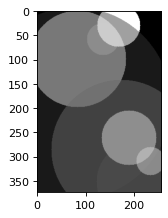

  0%|          | 4/350000 [00:00<5:17:25, 18.38it/s] 

Sigmas: 
 [[0.05011095 0.05       0.05       0.04986471 0.04967683]
 [0.05       0.05       0.05       0.05       0.05      ]
 [0.05269078 0.05       0.05       0.04827193 0.05039151]
 [0.04975385 0.05       0.05124331 0.04857408 0.0497906 ]
 [0.05       0.05       0.05       0.05       0.05      ]
 [0.05       0.05       0.05       0.05       0.05      ]
 [0.05       0.05       0.05       0.05       0.05      ]
 [0.05       0.05       0.05       0.05       0.05      ]
 [0.05       0.05       0.05       0.05       0.05      ]
 [0.05       0.05       0.05       0.05       0.05      ]
 [0.05       0.05       0.05       0.05       0.05      ]
 [0.05       0.05       0.05       0.05       0.05      ]
 [0.05152814 0.05       0.05       0.05054588 0.05      ]
 [0.05137042 0.05       0.04932896 0.05       0.05040686]
 [0.05       0.05       0.05       0.04952045 0.04933279]
 [0.05       0.05070766 0.05004015 0.05060979 0.05      ]]


  0%|          | 16/350000 [00:00<3:42:52, 26.17it/s]

In [ ]:
'''
__init__(self, 
                initial_chromosome_length,
                genotype_length,
                population_size, 
                 
                target_img,
                gray=False,
                ):
train(number_of_iterations=30000, 
              number_of_parents=6, 
              number_of_offspring_per_parent=3, 
              max_chromosome_length=256,
              initial_sigma_scale=5e-2,
              log_frequency=1,
              pararell=True
             ):
'''

es_model=EvoulationStrategy(initial_chromosome_length=8,
                           genotype_length=5,
                           population_size=16,
                           target_img=target_img,
                           gray=True)

#es_model.population=prev_pop.copy()
#es_model.sigmas=prev_sigmas.copy()

best_solution_objective_value, best_solution, best_solution_background,\
log_objective_values, log_best_solutions, log_best_backgrounds = es_model.train(
                                                          number_of_iterations=350000,
                                                          number_of_parents=6, 
                                                          number_of_offspring_per_parent=3, 
                                                          max_chromosome_length=256,
                                                          initial_sigma_scale=5e-2,
                                                          add_cricle_threshold=1e-2,
                                                          log_frequency=100,
                                                          update_frequency=50
    )

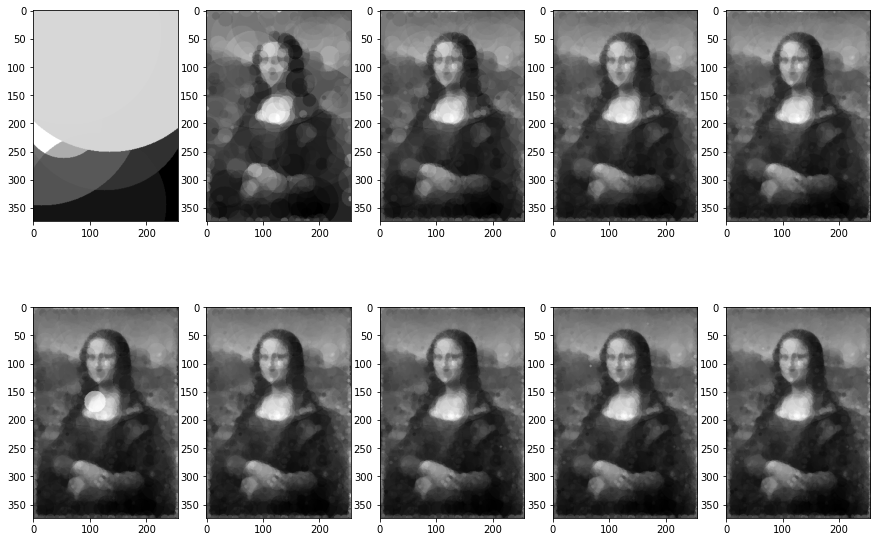

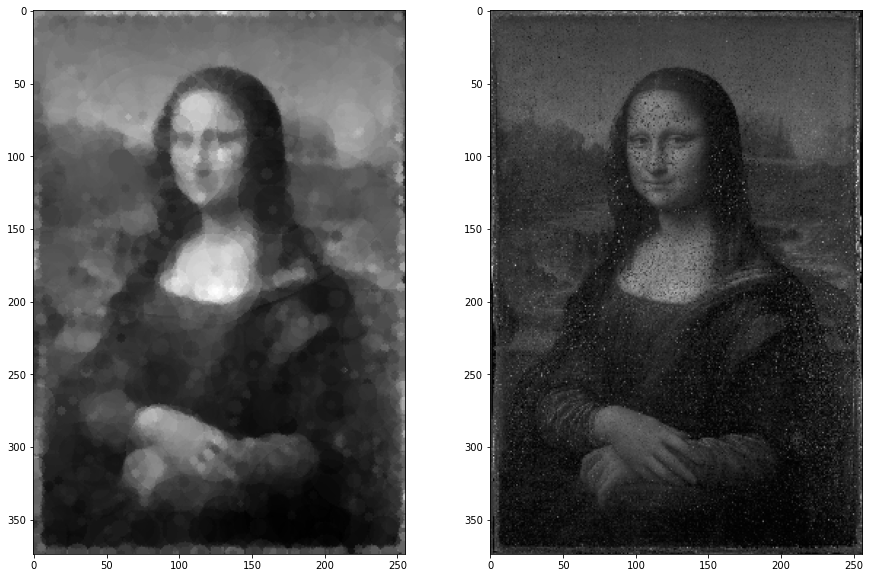

In [14]:
#mod_val=(10+len(log_best_solutions))//10

fig, axs = plt.subplots(2, 5, figsize=(15,10))
col_counter=0
row_counter=0
for i, X in enumerate(log_best_solutions):
   # if i%mod_val==0:
        axs[row_counter, col_counter].imshow(es_model.represent_individual(X, log_best_backgrounds[i]), cmap='gray')
        col_counter+=1
        if col_counter>4:
            col_counter=0
            row_counter+=1
        #draw_individual(represent_individual(X))
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(es_model.represent_individual(best_solution, best_solution_background), cmap='gray')
axs[1].imshow(es_model.target_img, cmap='gray')
plt.show()

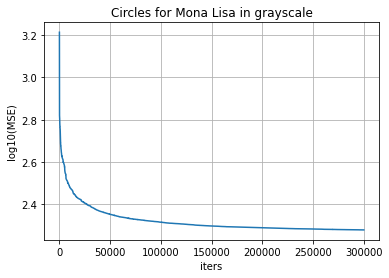

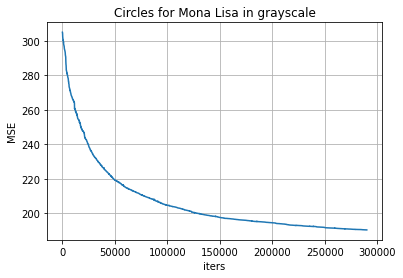

In [15]:
plt.plot(np.log10(log_objective_values[:,0]))
plt.grid()
plt.title("Circles for Mona Lisa in grayscale")
plt.ylabel('log10(MSE)')
plt.xlabel('iters')

plt.show()

plt.plot(log_objective_values[10000:,0])
plt.grid()
plt.title("Circles for Mona Lisa in grayscale")
plt.ylabel('MSE')
plt.xlabel('iters')

plt.show()